# Santa的接待安排
## 任务信息
### 任务背景
圣诞节前100天，Santa开放了workshop，欢迎以家庭单位的参观，如何更合理的安排这些家庭参观？

### 安排满足条件：
* 每天访问的人数需要在125-300人
* 每个家庭必须并且只安排一次参观

### 任务评价指标：Score = preference cost + accounting penalty（最小化该目标）
* preference cost：安排给每个家庭对应的choice需要额外的支出

|安排|礼品卡|每个家庭成员|
|--|--|--|
|Choice_0|不需要|不需要|
|Choice_1|50|不需要|
|Choice_2|50|9|
|Choice_3|100|9|
|Choice_4|200|9|
|Choice_5|200|18|
|Choice_6|300|18|
|Choice_7|300|36|
|Choice_8|400|36|
|Choice_9|500|235|
|otherwise|500|425|

* accounting penalty：Santa安排的财务成本

$$accounting penalty = \sum^1_{d=100}\frac{N_d-125}{400}N_d^{0.5+\frac{|N_d-N_{d+1}|}{50}}$$

    1. 其中 N(d) 代表当天安排人数
    2. N(d+1) 代表前一天安排人数（因为N代表距离圣诞节的天数）

### 数据描述：
* 每个家庭有10个选择choice0-9
* 数字代表了距离圣诞节的天数，比如 1代表12月24日
* 家庭数量 5000，即family_id 为[0, 4999]
* n_people 每个家庭人数

### 结果格式
|family_id|	assigned_day|
|--|--|
|0|	100|
|1|	99|
|2|	98|
|3|	97|
|……|	……|
|4999|	1|

## 数据加载

In [24]:
import pandas as pd

In [25]:
data = pd.read_csv('./family_data.csv')
data.head()

,family_id,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
0,0,52,38,12,82,33,75,64,76,10,28,4
1,1,26,4,82,5,11,47,38,6,66,61,4
2,2,100,54,25,12,27,82,10,89,80,33,3
3,3,2,95,1,96,32,6,40,31,9,59,2
4,4,53,1,47,93,26,3,46,16,42,39,4


In [26]:
import matplotlib.pyplot as plt

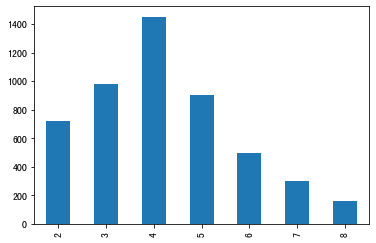

In [27]:
# 家庭人数可视化
data['n_people'].value_counts().sort_index().plot.bar()
plt.show()

# 数据定义
1. 将日期全部减1，方便矩阵索引
2. family_pcost：每个家庭安排在某一天的 preference cost 矩阵

In [28]:
import numpy as np

In [29]:
# 将日期全部减1，方便矩阵索引
for col in data.drop(['family_id', 'n_people'], axis=1).columns:
    data[col] = data[col] - 1
data.head()

,family_id,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
0,0,51,37,11,81,32,74,63,75,9,27,4
1,1,25,3,81,4,10,46,37,5,65,60,4
2,2,99,53,24,11,26,81,9,88,79,32,3
3,3,1,94,0,95,31,5,39,30,8,58,2
4,4,52,0,46,92,25,2,45,15,41,38,4


In [30]:
# 计算每个家庭安排在某一天的 preference cost
def get_family_pcost(choice, n_people):
    # choice对应的pcost
    temp_dict = {0:(0,0), 1:(50,0), 2:(50,9), 3:(100,9), 4:(200,9), 5:(200,28), 6:(300,18), 7:(300,36), 8:(400,36), 9:(500,235), 10:(500,425)}
    return temp_dict[choice][0] + temp_dict[choice][1] * n_people
    

# 每个家庭安排在某一天的 preference cost
family_pcost = np.ones(shape=(5000,100), dtype=np.int)    

for row_data, n_people in zip(data.drop(['family_id', 'n_people'], axis=1).iterrows(), data['n_people']):
    family_id, choice_days = row_data[0], row_data[1].values

    # choice 0-9 计算
    family_pcost[family_id, choice_days] = [get_family_pcost(x, n_people) for x in range(10)] 
    
    # choice之外的日期计算
    family_pcost[family_id][family_pcost[family_id] == 1] = get_family_pcost(10, n_people) 

In [31]:
# 计算 accounting penalty 矩阵
accounting_penalty = np.zeros(shape=(301, 301))

for N_d in range(len(accounting_penalty)):
    for N_d_1 in range(len(accounting_penalty)):
        if N_d_1 < 125 or N_d < 125:
            continue
        else:
            accounting_penalty[N_d, N_d_1] = (N_d - 125) / 400 * (N_d ** (0.5 + abs(N_d - N_d_1) / 50))

accounting_penalty

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 7.46610759, 8.36716954,
        9.37697794],
       [0.        , 0.        , 0.        , ..., 8.4302077 , 7.52185316,
        8.4302077 ],
       [0.        , 0.        , 0.        , ..., 9.51970597, 8.49339085,
        7.57772228]])

# 评判标准
1. check：是否符合两个条件
2. score：最终评分

In [32]:
# 条件判断
def check_family(df_assignment):
    if df_assignment['family_id'].nunique() != 5000:
        return False
    else:
        return True
    
def check_assigned_day(df_assignment, df_n_people):
    temp = pd.merge(df_assignment, df_n_people, on='family_id').groupby('assigned_day')['n_people'].sum().values
    if (temp < 125).any() or (temp > 300).any():
        return False
    else:
        return True

def check(df_assignment, df_n_people):
    if check_family(df_assignment) and check_assigned_day(df_assignment, df_n_people):
        return True
    else:
        return False

In [33]:
# score 计算
def score_preference_cost(df_assignment, family_pcost):
    family_id_array = df_assignment['family_id'].values
    family_cost_index = df_assignment['assigned_day'].values - 1
    return family_pcost[family_id_array, family_cost_index].sum()

def score_accounting_penalty(df_assignment, accounting_penalty, df_n_people):
    N_d = pd.merge(df_assignment, df_n_people, on='family_id').groupby('assigned_day')['n_people'].sum().values
    N_d = np.append(N_d, N_d[-1])
    return np.array([accounting_penalty[N_d[x], N_d[x+1]] for x in range(len(N_d)-1)]).sum()

def score(df_assignment, family_pcost, accounting_penalty, df_n_people):
    return score_preference_cost(df_assignment, family_pcost) + score_accounting_penalty(df_assignment, accounting_penalty, df_n_people)

In [34]:
# 最终评估
def evaluate(df_assignment, family_pcost, accounting_penalty, df_n_people):
    if not check(df_assignment, df_n_people):
        return -1
    else:
        return score(df_assignment, family_pcost, accounting_penalty, df_n_people)

In [35]:
# test
sub = pd.read_csv('./sample_submission.csv')
evaluate(sub, family_pcost, accounting_penalty, data)

10473697.403135022

# 随机求解

In [36]:
import random

In [37]:
%%time

sub_random = sub.copy()
best_random_score = evaluate(sub, family_pcost, accounting_penalty, data)

for i in range(100):
    sub_random['assigned_day'] = np.array([random.randint(1, 100) for x in range(len(sub))])
    result = evaluate(sub_random, family_pcost, accounting_penalty, data)
    if result > 0:
        if result < best_random_score:
            best_random_score = result
            best_random_assignment = sub_random.copy()
    
    print('round：{}'.format(i), end='\r' ,flush = True)
    
best_random_score

CPU times: user 2.26 s, sys: 17.3 ms, total: 2.28 s
Wall time: 2.92 s


10473697.403135022

# 概率随机求解
给予每个家庭前10的choice高概率

In [38]:
def softmax(array):
    return np.exp(array) / np.exp(array).sum(axis=1).reshape(-1, 1)

In [39]:
%%time

temp = family_pcost.copy()
temp[temp == 0] = 1
temp = softmax(1/temp)

sub_p_random = sub.copy()
best_p_random_score = evaluate(sub, family_pcost, accounting_penalty, data)
sep_list = [x for x in range(1, 101)]

for i in range(100):
    sub_p_random['assigned_day'] = np.array([np.random.choice(sep_list, p=temp[x]) for x in range(len(sub))])
    result = evaluate(sub_p_random, family_pcost, accounting_penalty, data)
    if result > 0:
        if result < best_p_random_score:
            best_p_random_score = result
            best_p_random_assignment = sub_p_random.copy()
    
    print('round：{}'.format(i), end='\r' ,flush = True)

best_p_random_score

CPU times: user 27.1 s, sys: 13 ms, total: 27.1 s
Wall time: 42.5 s


10384023.94306106

# preference cost 线性规划求解

In [40]:
from ortools.linear_solver import pywraplp
from functools import reduce

## 部分求解（线性求解）

In [48]:
# 线性求节器
solver = pywraplp.Solver('Santa', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

In [49]:
# 定义变量（0/1型，5000*100个，字典保存）
x = {(i,j): solver.BoolVar('x({},{})'.format(i,j)) for i in range(5000) for j in range(100)}
print('变量个数：', solver.NumVariables())

变量个数： 500000


In [50]:
# 约束1：每个家庭前10个choice只安排一次
for i in range(5000):
    family_seq = [x[(i,j)] for j in data.iloc[i].values[1:-1]]
    solver.Add(reduce(lambda x,y: x+y, family_seq) == 1)

# 约束2：每天访问人数在125到300之间
family_n_people = data['n_people'].values
for j in range(100):
    people_per_day_seq = [x[(i,j)]*family_n_people[i] for i in range(5000)]
    solver.Add(reduce(lambda x,y: x+y, people_per_day_seq) >= 125)
    solver.Add(reduce(lambda x,y: x+y, people_per_day_seq) <= 300)

# 约束3，前后两天访问人数相差不超过25人
DIFF = 20
current_day = [x[(i,0)]*family_n_people[i] for i in range(5000)]
for j in range(1, 100):
    next_day = [x[(i,j)]*family_n_people[i] for i in range(5000)]
    diff = reduce(lambda x,y: x+y, next_day) - reduce(lambda x,y: x+y, current_day)
    solver.Add(diff <= DIFF)
    solver.Add(diff >= -DIFF)
    current_day = next_day

print('约束个数：', solver.NumConstraints())

约束个数： 5398


In [51]:
%%time

# 优化问题求解（最小化）
pcost = reduce(lambda x,y: x+y, [x[(i,j)]*family_pcost[i,j] for i in range(5000) for j in range(100)])

solver.Minimize(pcost)
status = solver.Solve()

# 优化结果
print('status:', status)
print('optimal:', solver.Objective().Value())

status: 0
optimal: 76959.32142857143
CPU times: user 32.7 s, sys: 347 ms, total: 33 s
Wall time: 50 s


In [56]:
# 结果查看
result_dict = {'family_id':[], 'assigned_day':[]}
for i in range(5000):
    for j in range(100):
        if x[(i,j)].solution_value() > 0.9:
            result_dict['family_id'].append(i)
            result_dict['assigned_day'].append(j+1)

df_result = pd.DataFrame(result_dict)
df_result

,family_id,assigned_day
0,0,52
1,1,26
2,2,100
3,3,2
4,4,53
...,...,...
4931,4995,16
4932,4996,88
4933,4997,32
4934,4998,92


In [57]:
temp = df_result['family_id'].value_counts().sort_index()
fail_family_id = temp[temp != 1].index.values
succee_family_id = temp[temp == 1].index.values

In [62]:
len(fail_family_id)

64

In [25]:
df_result_part_1 = df_result[df_result['family_id'].isin(succee_family_id)]

## 余下未解部分（整型求解）

In [64]:
# 整型线性求节器
solver_int = pywraplp.Solver('Santa', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

In [65]:
# 定义变量
x_int = {(i,j): solver_int.BoolVar('x_int({},{})'.format(i,j)) for i in fail_family_id for j in range(100)}
print('变量个数：', solver_int.NumVariables())

变量个数： 6400


In [66]:
# 每天剩余容量
occupancy = pd.merge(df_result_part_1, data[['family_id', 'n_people']], on='family_id').groupby('assigned_day')['n_people'].sum().values
occupancy_max = 300 - occupancy
occupancy_min = 125 - occupancy

In [67]:
# 约束1：每个家庭只安排一次
for i in fail_family_id:
    family_seq = [x_int[(i,j)] for j in range(100)]
    solver_int.Add(reduce(lambda x,y: x+y, family_seq) == 1)

# 约束2：每天访问人数在大于125，小于剩余量
family_n_people = data['n_people'].values
for j in range(100):
    people_per_day_seq = [x_int[(i,j)]*family_n_people[i] for i in fail_family_id]
    solver_int.Add(reduce(lambda x,y: x+y, people_per_day_seq) >= occupancy_min[j])
    solver_int.Add(reduce(lambda x,y: x+y, people_per_day_seq) <= occupancy_max[j])

# 约束3，前后两天访问人数相差不超过40人
DIFF = 40
current_day = [x_int[(i,0)]*family_n_people[i] for i in fail_family_id]
for j in range(1, 100):
    next_day = [x_int[(i,j)]*family_n_people[i] for i in fail_family_id]
    diff = reduce(lambda x,y: x+y, next_day) - reduce(lambda x,y: x+y, current_day) + occupancy[j] - occupancy[j-1]
    solver_int.Add(diff <= DIFF)
    solver_int.Add(diff >= -DIFF)
    current_day = next_day

print('约束个数：', solver_int.NumConstraints())

约束个数： 462


In [68]:
%%time

# 优化问题求解（最小化）
pcost = reduce(lambda x,y: x+y, [x_int[(i,j)]*family_pcost[i,j] for i in fail_family_id for j in range(100)])

solver_int.Minimize(pcost)
status = solver_int.Solve()

# 优化结果
print('status:', status)
print('optimal:', solver_int.Objective().Value())

status: 0
optimal: 1301.0
CPU times: user 1.29 s, sys: 90.8 ms, total: 1.38 s
Wall time: 3 s


In [69]:
# 结果查看
result_dict = {'family_id':[], 'assigned_day':[]}
for i in fail_family_id:
    for j in range(100):
        if x_int[(i,j)].solution_value() != 0.0:
            result_dict['family_id'].append(i)
            result_dict['assigned_day'].append(j+1)

df_result_part_2 = pd.DataFrame(result_dict)
df_result_part_2

,family_id,assigned_day
0,97,96
1,233,92
2,244,39
3,248,33
4,295,47
...,...,...
59,4898,46
60,4914,39
61,4918,59
62,4936,74


# 合并结果

In [32]:
df_finall = pd.concat([df_result_part_1, df_result_part_2], axis=0).sort_values('family_id').reset_index(drop=True)
print('规划结果：${:.0f}'.format(evaluate(df_finall, family_pcost, accounting_penalty, data)))

规划结果：$78489


# 模型调优

In [59]:
# 每个家庭重新选择前10个choice
epoch = 0
best_score = evaluate(df_finall, family_pcost, accounting_penalty, data)
best_assigned = df_finall.copy()
fine_tune_data = data.drop(['n_people', 'family_id'], axis=1).values
stop = 1

while stop > 0:
    epoch += 1
    stop = 0
    
    df_current = best_assigned.copy()
    
    for index, iter_data in df_current.iterrows():
        temp = iter_data[1]
        
        for i in range(10):
            choice_day = fine_tune_data[index, i]
            iter_data[1] = choice_day
            current_score = evaluate(df_current, family_pcost, accounting_penalty, data)
            
            if current_score < best_score and current_score > 0:
                stop += 1
                best_score = current_score
                best_assigned = df_current.copy()
                print('epoch:{}, family_id:{:<4}, day:{:<3} --> {:<3}(choice_{}), best_score:{:.0f}'.format(epoch, index, temp, choice_day, i, best_score))
            
            print('epoch:{} id:{}'.format(epoch, index), end='\r', flush=True)
            
        iter_data[1] = temp
        
            

epoch:1, family_id:35  , day:31  --> 87 (choice_5), best_score:78487
epoch:1, family_id:76  , day:79  --> 46 (choice_5), best_score:78463
epoch:1, family_id:150 , day:72  --> 60 (choice_4), best_score:78349
epoch:2, family_id:35  , day:31  --> 87 (choice_5), best_score:78348
epoch:2, family_id:76  , day:79  --> 46 (choice_5), best_score:78324
epoch:2, family_id:217 , day:5   --> 38 (choice_2), best_score:78297
epoch:2, family_id:402 , day:63  --> 25 (choice_6), best_score:78272
epoch:2, family_id:620 , day:79  --> 52 (choice_6), best_score:78227
epoch:2, family_id:4151, day:69  --> 68 (choice_3), best_score:78226
epoch:3, family_id:35  , day:31  --> 87 (choice_5), best_score:78224
epoch:3, family_id:76  , day:79  --> 46 (choice_5), best_score:78200
epoch:3, family_id:217 , day:5   --> 38 (choice_2), best_score:78173
epoch:3, family_id:402 , day:63  --> 25 (choice_6), best_score:78149
epoch:3, family_id:620 , day:79  --> 52 (choice_6), best_score:78104
epoch:4, family_id:35  , day:31  -

epoch:23, family_id:1369, day:93  --> 87 (choice_8), best_score:77094
epoch:23, family_id:1878, day:50  --> 73 (choice_4), best_score:77086
epoch:23, family_id:3390, day:65  --> 95 (choice_8), best_score:77084
epoch:24, family_id:35  , day:31  --> 87 (choice_5), best_score:77081
epoch:24, family_id:76  , day:79  --> 46 (choice_5), best_score:77061
epoch:24, family_id:1115, day:31  --> 96 (choice_6), best_score:77060
epoch:24, family_id:1369, day:93  --> 87 (choice_8), best_score:77059
epoch:24, family_id:1878, day:50  --> 73 (choice_4), best_score:77051
epoch:25, family_id:35  , day:31  --> 87 (choice_5), best_score:77049
epoch:25, family_id:76  , day:79  --> 46 (choice_5), best_score:77029
epoch:25, family_id:1115, day:31  --> 96 (choice_6), best_score:77027
epoch:25, family_id:1369, day:93  --> 87 (choice_8), best_score:77027
epoch:25, family_id:3710, day:69  --> 73 (choice_7), best_score:77020
epoch:26, family_id:35  , day:31  --> 87 (choice_5), best_score:77018
epoch:26, family_id:

In [187]:
evaluate(best_assigned, family_pcost, accounting_penalty, data)

76659.74215728356

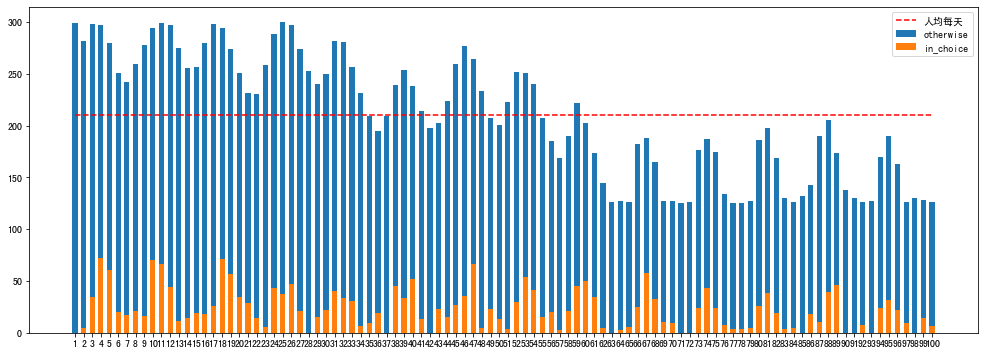

In [188]:
temp_best_assigned = pd.merge(best_assigned, data, on='family_id')

plt.figure(figsize=(17, 6))
plt.bar([x for x in range(1, 101)], temp_best_assigned.groupby('assigned_day')['n_people'].sum().values, width=0.6, label='otherwise')

assign_day = temp_best_assigned['assigned_day'].values
choice = temp_best_assigned.drop(['assigned_day', 'n_people', 'family_id', 'n_people'], axis=1).values

in_choice = []
for i, j in zip(assign_day, choice):
    if i in j:
        in_choice.append(1)
    else:
        in_choice.append(0)
        
temp_best_assigned['in_choice'] = in_choice
in_choice_data = temp_best_assigned[temp_best_assigned['in_choice'] == 1].groupby('assigned_day')['n_people'].sum().reset_index()
index = in_choice_data['assigned_day']
in_choice_data_array = np.zeros(100)
in_choice_data_array[in_choice_data['assigned_day'].values] = in_choice_data['n_people'].values
plt.bar([x for x in range(1, 101)], in_choice_data_array, label='in_choice', width=0.6)

plt.hlines(temp_best_assigned['n_people'].sum() / 100, 1, 100, colors='r', linestyles='--', label='人均每天')
plt.xticks(ticks=[x for x in range(1, 101)], labels=[x for x in range(1, 101)])
plt.legend()
plt.show()